In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
cnxn = create_engine('sqlite:///vn.db')

In [3]:
query = "SELECT * FROM HSX WHERE ticker = 'PVT' ORDER BY date"

In [4]:
df = pd.read_sql(query, cnxn, parse_dates=['date'])

In [5]:
df.tail()

,ticker,date,open,high,low,close,volume
1790,PVT,2020-08-19,11.00,11.15,10.8,11.00,914130.0
1791,PVT,2020-08-20,11.00,11.00,10.8,10.85,784810.0
1792,PVT,2020-08-21,10.90,11.05,10.8,10.90,1543100.0
1793,PVT,2020-08-24,11.00,11.10,10.9,11.00,2342890.0
1794,PVT,2020-08-25,11.05,11.15,10.9,10.90,1547620.0


In [10]:
df['mid'] = (df['high'] + df['low']) / 2

In [6]:
train_set = df.iloc[:-40,:]['close']
test_set = df.iloc[-40:,:]['close']

In [7]:
day_to_window = 90

In [9]:
sc = MinMaxScaler(feature_range=(0,1))
stage_train = sc.fit_transform(train_set.values.reshape(-1,1))
X_train = []
y_train = []
for i in range(day_to_window, len(stage_train)):
    X_train.append(stage_train[i-day_to_window:i, :])
    y_train.append(stage_train[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
dataset_total = pd.concat((train_set, test_set), axis = 0)
inputs = dataset_total[len(df) - len(test_set) - day_to_window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(day_to_window, day_to_window + len(test_set)):
    X_test.append(inputs[i-day_to_window:i, :])
    y_test.append(inputs[i, :])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

nn = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200)#, batch_size = 32)

e_error: 0.0172
Epoch 86/200
52/52 [==============================] - 4s 81ms/step - loss: 9.6992e-04 - mean_absolute_error: 0.0236 - val_loss: 3.4401e-04 - val_mean_absolute_error: 0.0136
Epoch 87/200
52/52 [==============================] - 4s 81ms/step - loss: 9.5956e-04 - mean_absolute_error: 0.0233 - val_loss: 2.9465e-04 - val_mean_absolute_error: 0.0113
Epoch 88/200
52/52 [==============================] - 4s 81ms/step - loss: 9.0367e-04 - mean_absolute_error: 0.0226 - val_loss: 2.5791e-04 - val_mean_absolute_error: 0.0100
Epoch 89/200
52/52 [==============================] - 4s 83ms/step - loss: 9.5004e-04 - mean_absolute_error: 0.0231 - val_loss: 2.5888e-04 - val_mean_absolute_error: 0.0099
Epoch 90/200
52/52 [==============================] - 4s 80ms/step - loss: 8.7055e-04 - mean_absolute_error: 0.0225 - val_loss: 4.1883e-04 - val_mean_absolute_error: 0.0167
Epoch 91/200
52/52 [==============================] - 4s 83ms/step - loss: 9.5642e-04 - mean_absolute_error: 0.0233 - v

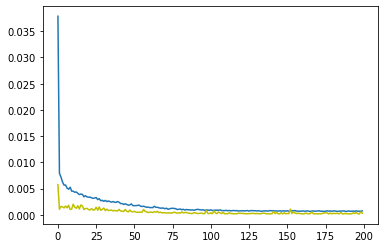

In [12]:
fig, ax = plt.subplots()
ax.plot(nn.history['loss'])
ax.plot(nn.history['val_loss'], color='y')

In [13]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [14]:
real = test_set.values

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='real',
        x=df.iloc[-40:,:]['date'],
        y=real.flatten()
    )
)

fig.add_trace(
    go.Scatter(
        name='pred',
        x=df.iloc[-40:,:]['date'],
        y=predicted_stock_price.flatten()
    )
)
fig.show()

In [40]:
mean_squared_error(real, predicted_stock_price)

5.409361499134738

In [ ]:
0.08086984669252982